### Dog Breed classificatiThis notebook builds an end-to-end multi-class image classifier using TenserFlow 2.0 and TenserFlow Hub

We're going to take the following approach:

1. Problem Definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation 

### 1. Problem Definition

> Identifying the breed of a dog given image of a dog.

### 2. Data
The data came from kaggle's <a href='https://www.kaggle.com/c/dog-breed-identification/data'>dog breed identification competition</a>

### 3.Evaluation

The evaluation is a file with prediction probabilities for each dog breed for each test image.

### 4. Features

- Some information about the data:
We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
- There are 120 breeds of dogs (this means there are 120 different classes).
- There are around 10,000+ images in training set (these images have labels).
- There are around 10,000+ images in test set(these images have no labels, because we'll want to predict them).


### Preparing the tools
- import Tensorflow
- import TensorflowHub
- make sure we're using GPU

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
print('TF version: ',tf.__version__)
print('TF Hub version: ',hub.__version__)

TF version:  2.2.0-rc2
TF Hub version:  0.8.0


In [2]:

# Check for GPU availability
print('GPU : Available' if tf.config.list_physical_devices('GPU') else 'GPU : Not Available')

GPU : Available


### Getting our data ready (turning into Tensors)
With all machine learning models, our data has to be in numerical format.

Let's start by accessing our data and checking out thr labels.

In [3]:
import pandas as pd
labels=pd.read_csv('/content/drive/My Drive/dog-vision/labels.csv')
labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [5]:
labels.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     c13427fc3db9194dac02b1721bd10fe4  scottish_deerhound
freq                                   1                 126

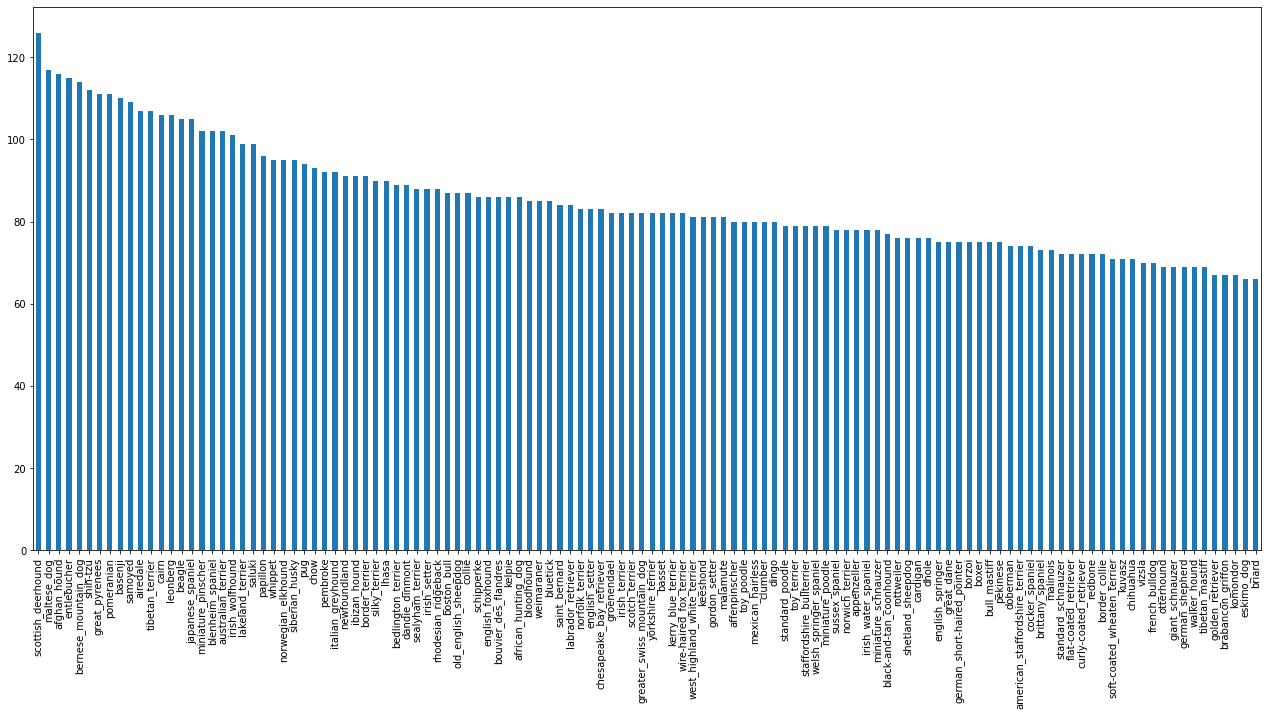

In [6]:
import matplotlib.pyplot as plt
labels['breed'].value_counts().plot.bar(figsize=(22,10))


In [7]:
labels['breed'].value_counts().max()

126

In [8]:
labels['breed'].value_counts().median()

82.0

In [9]:
labels['breed'].value_counts().min()

66

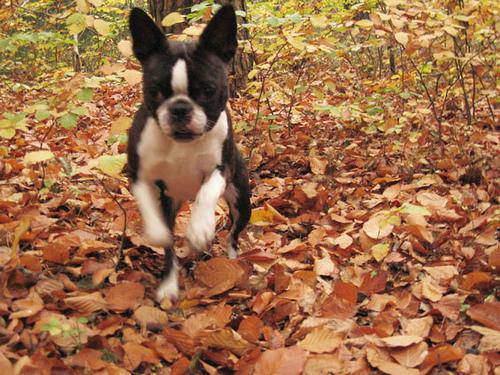

In [10]:
# Lets view an image
from IPython.display import  Image
Image('drive/My Drive/dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg')

As per the Google documentation, There should be atleast 10 images per class, But 100 images per class is better.

### Getting all images and their labels

Lets get a list of all ourimages pathnames

In [11]:
labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [12]:
# Create pathname from Image id

filename=['drive/My Drive/dog-vision/train/'+fname+'.jpg' for fname in labels.id]
filename[:10]

['drive/My Drive/dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/dog-vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/dog-vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/dog-vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/dog-vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/dog-vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/dog-vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/dog-vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/dog-vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/dog-vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [13]:
# Check whether number of filename matches number of actual image file
import os
if len(os.listdir('drive/My Drive/dog-vision/train/'))==len(filename):
  print('Number of files matched')
else:
  print('Something went wrong please try again')

Number of files matched


In [14]:
os.listdir('drive/My Drive/dog-vision/train/')[:5]

['edf5071a8b480af1212710874ad2c05e.jpg',
 'f2fd565d275c740f2f4dd91f0759b9df.jpg',
 'f6c308322ba8e80c9ad20f9b292a8c4c.jpg',
 'f055e34fcd3c7a941868a371821feb14.jpg',
 'ef1bdfc864035ed213fd676c24ba14f0.jpg']

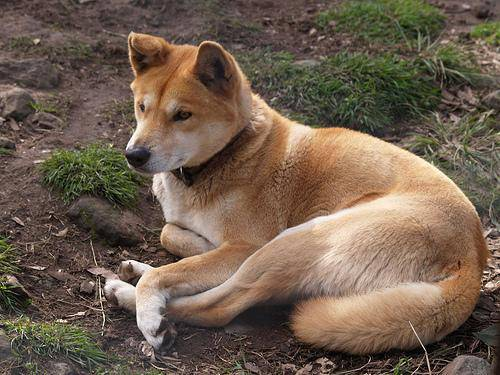

In [15]:
Image(filename[4000])

In [16]:
labels['breed'][6000]

'french_bulldog'

Since we've now got training images filepaths in a list, lets prepare our labels..

In [17]:
import numpy as np
labels_breeds=labels.breed
labels_breeds=np.array(labels_breeds)
labels_breeds

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [18]:
len(labels_breeds)

10222

In [19]:
if len(labels_breeds)==len(filename):
  print('Success')
else:
  print('failure')

Success


In [20]:
# find unique labels
unique_labels=np.unique(labels_breeds)
len(unique_labels)

120

In [21]:
# turn a single label into array of booleans
labels_breeds[0]==np.unique(labels_breeds)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [22]:
# Turn every label into array of boolean
boolean_labels=[label== unique_labels for label in labels_breeds]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [23]:
len(boolean_labels)

10222

In [24]:
# Example : Turning boolean array into integers
print(labels_breeds[0])
print(np.where(unique_labels==labels_breeds[0]))
print(boolean_labels[0].argmax())
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [25]:
print(labels_breeds[1])
print(np.where(unique_labels==labels_breeds[1]))
print(boolean_labels[1].argmax())
print(boolean_labels[1].astype(int))

dingo
(array([37]),)
37
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


## Creating our own validation set

Since the dataset from kaggle does not come with validation set we are goinng to create our own

In [0]:
# Setup x and y variable
x=filename
y=boolean_labels

We are going to start of experimenting with ~1000 images and increase as needed

In [0]:
#Set number of images to use for experimenting
NUM_IMAGES=1000 #@param {type:'slider',min:1000,max:10000}

In [28]:
# lets split our data into train and validation set
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(x[:NUM_IMAGES],
                                             y[:NUM_IMAGES],
                                             test_size=0.2,
                                             random_state=42)

len(x_train),len(x_val),len(y_val),len(y_train)

(800, 200, 200, 800)

In [29]:
# Let's have a gaze at the training data
x_train[:2], y_train[:2]

(['drive/My Drive/dog-vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/dog-vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, F

### Preprocessing Images(turning images into tensor)

To preprocess our images into tensors we're going to write a function which does a few things

- Take an image filepath as input
- Use TensorFlow to read the file and save it to variable, image
- Turn our image (a jpg) into Tensors
- Normalize our image ( convert color channel values from 0-255 to 0-1 )
- Resize the image to be shape of (224, 224)
- Return the modefied image

Before we do, let's see what importing an image looks like

In [30]:
# Convert image to numpy array
from matplotlib.pyplot import  imread
image=imread(filename[42])
image.shape

(257, 350, 3)

In [31]:
image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

In [32]:
image.min(), image.max()

(0, 255)

In [33]:
# Turn image into Tensors
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

In [0]:
# define image size
IMG_SIZE=224

def preprocess_image(image_path,img_size=IMG_SIZE):
  # read in image file
  image=tf.io.read_file(image_path)

  # Turn jpg image into numerical tensor  with 3 color channels
  image=tf.image.decode_jpeg(image,channels=3)

  # COnvert the color channel value fromm 0-255 to 0-1
  image=tf.image.convert_image_dtype(image,tf.float32)

  # Resize the image to desired value
  image = tf.image.resize(image,size=[IMG_SIZE,IMG_SIZE])

  # Return the image
  return image

In [35]:
tensor = tf.io.read_file(filename[0])
tensor

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01w\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

In [36]:
# Converting image file image file to numerical tensors
tensor = tf.image.decode_jpeg(tensor, channels=3)
tensor

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[107,  45,   0],
        [151,  91,  41],
        [177, 119,  69],
        ...,
        [175, 143,  68],
        [189, 157,  82],
        [213, 181, 106]],

       [[150,  92,  46],
        [179, 121,  75],
        [164, 110,  63],
        ...,
        [167, 136,  56],
        [171, 140,  60],
        [187, 156,  76]],

       [[150,  97,  55],
        [187, 136,  93],
        [161, 112,  69],
        ...,
        [199, 168,  78],
        [193, 162,  72],
        [200, 169,  79]],

       ...,

       [[188, 121,  66],
        [185, 118,  63],
        [182, 117,  63],
        ...,
        [213, 160, 106],
        [211, 158, 104],
        [208, 155, 101]],

       [[185, 118,  63],
        [183, 116,  61],
        [182, 117,  63],
        ...,
        [196, 144,  86],
        [199, 147,  90],
        [199, 147,  89]],

       [[181, 114,  59],
        [181, 114,  59],
        [181, 116,  62],
        ...,
        [184, 132,  7

In [37]:
# Converting from 0-255 to 0-1 makes our computing effcient
# It's called normalization
tf.image.convert_image_dtype(tensor, tf.float32)

<tf.Tensor: shape=(375, 500, 3), dtype=float32, numpy=
array([[[0.41960788, 0.1764706 , 0.        ],
        [0.5921569 , 0.35686275, 0.16078432],
        [0.69411767, 0.4666667 , 0.27058825],
        ...,
        [0.6862745 , 0.56078434, 0.26666668],
        [0.7411765 , 0.6156863 , 0.32156864],
        [0.8352942 , 0.70980394, 0.4156863 ]],

       [[0.5882353 , 0.36078432, 0.18039216],
        [0.7019608 , 0.47450984, 0.29411766],
        [0.6431373 , 0.43137258, 0.24705884],
        ...,
        [0.654902  , 0.53333336, 0.21960786],
        [0.67058825, 0.54901963, 0.23529413],
        [0.73333335, 0.6117647 , 0.29803923]],

       [[0.5882353 , 0.3803922 , 0.21568629],
        [0.73333335, 0.53333336, 0.3647059 ],
        [0.6313726 , 0.43921572, 0.27058825],
        ...,
        [0.7803922 , 0.65882355, 0.30588236],
        [0.7568628 , 0.63529414, 0.28235295],
        [0.7843138 , 0.6627451 , 0.30980393]],

       ...,

       [[0.7372549 , 0.47450984, 0.25882354],
        [0.72

In [38]:
preprocess_image(x[42])

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3264178 , 0.5222886 , 0.3232816 ],
        [0.2537167 , 0.44366494, 0.24117757],
        [0.25699762, 0.4467087 , 0.23893751],
        ...,
        [0.29325107, 0.5189916 , 0.3215547 ],
        [0.29721776, 0.52466875, 0.33030328],
        [0.2948505 , 0.5223015 , 0.33406618]],

       [[0.25903144, 0.4537807 , 0.27294815],
        [0.24375686, 0.4407019 , 0.2554778 ],
        [0.2838985 , 0.47213382, 0.28298813],
        ...,
        [0.2785345 , 0.5027992 , 0.31004712],
        [0.28428748, 0.5108719 , 0.32523635],
        [0.28821915, 0.5148036 , 0.32916805]],

       [[0.20941195, 0.40692952, 0.25792548],
        [0.24045378, 0.43900946, 0.2868911 ],
        [0.29001117, 0.47937486, 0.32247734],
        ...,
        [0.26074055, 0.48414773, 0.30125174],
        [0.27101526, 0.49454468, 0.32096273],
        [0.27939945, 0.5029289 , 0.32934693]],

       ...,

       [[0.00634795, 0.03442048, 0.0258106 ],
        [0.01

`Batch` Small portion of your data , 32 is a fefault batch size with the most machine learning models

### Turning Our data into batches

Why turn our data into batches ?
Let's say you are trying to process 10000 + images in one go they all might not fit into memory

So that's why we do about 32 (this is batch size) images at a time (you can manually adjust the batch size if needed)

In order to use TensorFlow effectively we need our data in the form of Tensor tuple which look like this (image, label).

In [0]:
## Create a simple function to return tuple( image , label)

def get_image_label(image_path,label):
  image=preprocess_image(image_path)
  return image,label

In [40]:
x[:2],y[:2]

(['drive/My Drive/dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
  'drive/My Drive/dog-vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, F

In [41]:
# Demo of above function
get_image_label(tf.constant(x[42]),tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: (image, label), let's make a function to turn all of our data (X & y) into batches!

In [0]:
BATCH_SIZE=32

def create_data_batches(x,y=None,batch_size=BATCH_SIZE,valid_data=False,test_data=False):
  '''
  Create batched of data out of image and label pairs.
  Shuffles the data if its training data but doesnt shuffle if its validation data
  Also accepts test data as input
  '''
  # tf.constants -create a constant tensor from a tensor like object
  if test_data:
    print('Creating test data branches....')
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x)))# this says, pass me some
    # tensor and I'll create dataset out of that
    data_batch=data.map(preprocess_image).batch(BATCH_SIZE)
    return data_batch
  # If the data is valid dataset , we don't  need to shuffle it
  elif valid_data:
    print('Creating validation data batches....')
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x),# filepaths
                                             tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE) # process the image and turn it into the batch
    return data_batch
  else:
    print('create training data batches ...')
    data=tf.data.Dataset.from_tensor_slices((tf.constant(x),# filepaths
                                             tf.constant(y))) # labels
    #process the image and turn it into batch
    data_batch=data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [43]:
# creating training and validation data batches
train_data=create_data_batches(x_train,y_train)
val_data=create_data_batches(x_val,y_val,valid_data=True)

create training data batches ...
Creating validation data batches....


In [44]:
# Check out the different attributes of out data batches
train_data.element_spec,val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

Exploring above function

In [45]:
x[:5]

['drive/My Drive/dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/dog-vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/dog-vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/dog-vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/dog-vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [46]:
data=tf.constant(x)
data

<tf.Tensor: shape=(10222,), dtype=string, numpy=
array([b'drive/My Drive/dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
       b'drive/My Drive/dog-vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
       b'drive/My Drive/dog-vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
       ...,
       b'drive/My Drive/dog-vision/train/ffe2ca6c940cddfee68fa3cc6c63213f.jpg',
       b'drive/My Drive/dog-vision/train/ffe5f6d8e2bff356e9482a80a6e29aac.jpg',
       b'drive/My Drive/dog-vision/train/fff43b07992508bc822f33d8ffd902ae.jpg'],
      dtype=object)>

In [47]:
## type and length

len(data), type(data)

(10222, tensorflow.python.framework.ops.EagerTensor)

In [48]:
# creating dataset -> pass file paths and labels in the form of Tensor constants
tensor_data_set=tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                                    tf.constant(y)))
tensor_data_set

<TensorSliceDataset shapes: ((), (120,)), types: (tf.string, tf.bool)>

In [49]:
# creates (image,label) tuples (this also turns the image path into a preprocessed image)
# this also turns the tensor data set into batched

tensor_image_label=tensor_data_set.map(get_image_label)
tensor_image_label

<MapDataset shapes: ((224, 224, 3), (120,)), types: (tf.float32, tf.bool)>

In [50]:
tensor_batches = tensor_image_label.batch(BATCH_SIZE)
tensor_batches

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend let's visualize them.



In [0]:
import matplotlib.pyplot as plt

# create a function foor viewing images in data batch
def show_25_images(images,label):
  '''
  Display a plot of 25 images and their labels from a data batch
  '''
  plt.figure(figsize=(10,10))
  
  # Loop through 25 
  for i in range(25):
    # create subplots 5 rows, 5 columns
    ax=plt.subplot(5,5,i+1)
    # display image
    plt.imshow(images[i])
    # Add the image label as title
    plt.title(unique_labels[label[i].argmax()],color='white')

    # Turn the grid lines off
    plt.axis('off')

In [52]:
# next()-> Returns next item from iterator
# the below function is gonna taakeour batch dataset , and going to unwind it from batch and turn it
# numpy iterator
train_images,train_labels=next(train_data.as_numpy_iterator())
train_images,train_labels

(array([[[[0.04452813, 0.0484497 , 0.05629283],
          [0.05633019, 0.06025176, 0.06809489],
          [0.04290967, 0.04683124, 0.05467437],
          ...,
          [0.07345551, 0.02696446, 0.0128119 ],
          [0.08338569, 0.06167922, 0.02458122],
          [0.09094839, 0.07918368, 0.04653312]],
 
         [[0.03778223, 0.04562537, 0.04161626],
          [0.0300378 , 0.03788094, 0.03387184],
          [0.07026608, 0.07810921, 0.07410011],
          ...,
          [0.2120701 , 0.20385231, 0.15405536],
          [0.06193235, 0.04972087, 0.03209355],
          [0.01333135, 0.00152287, 0.00104142]],
 
         [[0.08905759, 0.1049627 , 0.08513602],
          [0.09621842, 0.11212353, 0.09229685],
          [0.05104753, 0.06695264, 0.04712596],
          ...,
          [0.17335822, 0.20798706, 0.14030793],
          [0.3077376 , 0.30949864, 0.20433936],
          [0.37611565, 0.36580402, 0.250109  ]],
 
         ...,
 
         [[0.42239693, 0.37925968, 0.25376946],
          [0.50562

In [53]:
# first batch
len(train_images),len(train_labels)

(32, 32)

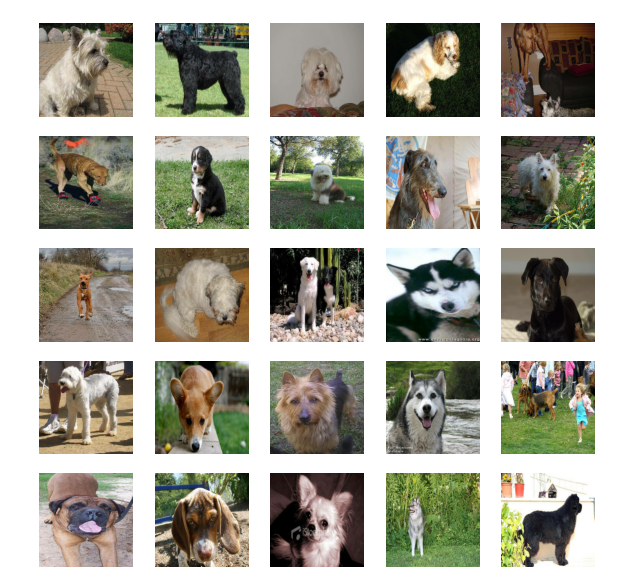

In [54]:
# now lets visualize the data in training batch
train_images,train_labels=next(train_data.as_numpy_iterator())
show_25_images(train_images,train_labels)

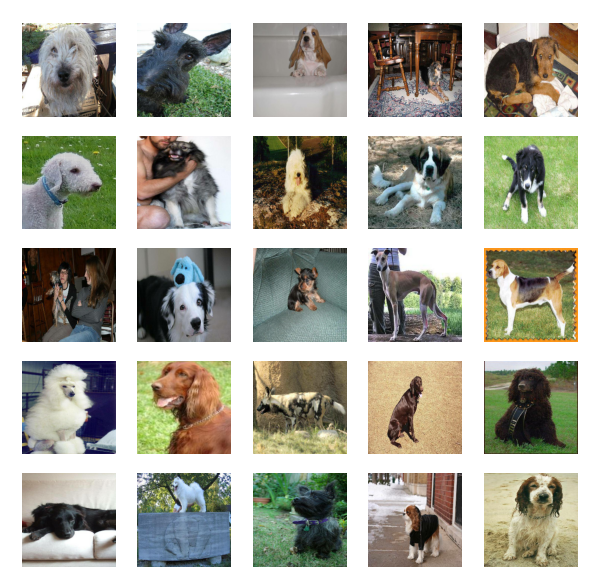

In [55]:
val_images,val_labels=next(val_data.as_numpy_iterator())
show_25_images(val_images,val_labels)

## Building a model

before we build a model, there are few things we need to define

- The input shape(our images shape, in the form of tensors)
- The output shape(image labels in the form of tensors)
- The URl of the model we want to use from <a href='https://tfhub.dev/s?module-type=image-classification'>TensorFlow Hub</a>

In [56]:
IMG_SIZE

224

In [0]:
# Setup input shape of the model
INPUT_SHAPE=[None,IMG_SIZE,IMG_SIZE,3]# batch, height,width,channels

# Output shape
OUTPUT_SHAPE=len(unique_labels)

# setup model URL from tensorflow hub
MODEL_URL='https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

Now we've got out input , output and model ready to go lets put them together into a keras deep learning model

Knowing this let's create a function which:
- Takes the input shape, output shape and the model we've chosen as parameters
- Define the layers in a keras model in sequential fashion
- Compiles the model
- Builds the model
- Returns the model

`keras` - This is a high level api to build and train model that includes first class support for tensorflow specific functionality.

In [0]:
# Create a function which builds a keras model

# we are using image size 224,224 cause that is the size that mobilenet model trained on

def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
  print(f'Building model with {model_url}')

  # setup the model layers / Instantiate model
  model=tf.keras.Sequential([hub.KerasLayer(model_url),# Layer 1 IT's telling Tensorflow hub
                             # To create keras layers of model_url
                             tf.keras.layers.Dense(units=output_shape,# 120 patterns
                                                   activation='softmax')# layer 2 output layer
                             ])
  # softmax converts patterns between 0-1
  # if we work with binary classification the activation function is 'sigmoid'

  # Compile the model
  model.compile(
      # loss is the measure of how well the model is guessing the higher the loss worse the prediction
      # lower the loss better the model is learning
      loss=tf.keras.losses.CategoricalCrossentropy(),# for binary classification use binarycrossentropy()
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy']
  )
  # builds the model
  model.build(input_shape)
  return model

In [59]:
model=create_model()
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

callbacks are the helper fucntion a model can use during training to do such things as save it's progress, check it's progress or stop training early if the model stops improving

We'll create 2 callbacks one for TensorBoard which helps to track our model's progress and another for early stopping which prevents our model from training to long and cause overfitting.

### TensorBoard callback

To setup the tensorBoard callback we need to do 3 things:

1. Load the TensorBoard notebook extension
2. Create a tensorboard callback which is able to save log files and pass it out moodel `fit()` function
3. visualize out models training logs with %tensorboard magic function

In [0]:
# Load the tensorboard notebook extension
%load_ext tensorboard

In [0]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join('/content/drive/My Drive/dog-vision/logs',
                # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime('%Y%m%d-%H:%M:%S'))
  
  return tf.keras.callbacks.TensorBoard(logdir)

### Early stopping call backs

Now let's create an early stopping callback early stopping helps prevent overfitting. If a model trains for too long it can actually do so well at finding patterns in a certain dataset that it's not able to use those patterns on a nother data set. So it doesn't generalize well.

**Example:**

If you were to learn the course materials far too well you learnt them off by heart a.k.a. if you're in university and you've studied way too hard on the course materials you've memorized them off by heart.

So When it come to a practice exam or a final exam with questions that you haven't seen before and you memorized everything on course materials instead of just learning the inherent problem solving patterns of the course materials you're not going to do very well on the practice exam or the final exam.

In [0]:
# create a early stopping callback

early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)

## Training a model (on subset of data)

our first model is only going to train 1000 image to make sure everthing is working correctly.

In [0]:
# number of epochs is how many passes of the data
# pass is you can imagine is equivalent to our model trying to find out patterns
# in each dog image
NUM_EPOCHS=100#@param {type:'slider',min:10,max:100,step:10}

one epoch would be giving our model a single chance to look at all the training data and then validating it from their.

100 epochs means we're giving our model up to 100 chances to go through the training dataset and figure out the patterns.

In [64]:
# check if gpu is available
print('GPU: available' if tf.config.list_logical_devices('GPU') else 'GPU not available')

GPU: available


## Lets create a function which trains a model
- create a model using create_model()
- setup a tensorboard callback using create_tensorboard_callbacks()
- call the fit()
- return the model
 

In [0]:

# Build a function train and return trained model
def train_model2():
  '''
  Trains a given model and returns the trained version
  '''

  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callback we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  # return the fitted model
  return model

In [66]:
model=train_model2()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 413s 17s/step - loss: 4.6416 - accuracy: 0.0900 - val_loss: 3.3373 - val_accuracy: 0.2850
Epoch 2/100
25/25 [==============================] - 5s 218ms/step - loss: 1.5540 - accuracy: 0.7100 - val_loss: 2.0959 - val_accuracy: 0.5200
Epoch 3/100
25/25 [==============================] - 5s 217ms/step - loss: 0.5284 - accuracy: 0.9538 - val_loss: 1.6442 - val_accuracy: 0.5900
Epoch 4/100
25/25 [==============================] - 5s 216ms/step - loss: 0.2450 - accuracy: 0.9875 - val_loss: 1.4822 - val_accuracy: 0.6300
Epoch 5/100
25/25 [==============================] - 6s 220ms/step - loss: 0.1450 - accuracy: 0.9950 - val_loss: 1.4028 - val_accuracy: 0.6400
Epoch 6/100
25/25 [==============================] - 6s 221ms/step - loss: 0.0997 - accuracy: 1.0000 - val_loss: 1.3549 - val_accuracy: 0.6550
Epoch 7/100
25/25 [==============================]

In [82]:
%tensorboard --logdir drive/My\ Drive/dog-vision/logs

<IPython.core.display.Javascript object>

In [83]:
# Making and evaluating predictions using trained model

predictions= model.predict(val_data,verbose=1)
predictions

7/7 [==============================] - 1s 126ms/step


array([[1.40048831e-03, 3.74837800e-05, 2.77348678e-04, ...,
        1.39540891e-04, 3.67095236e-05, 3.22794076e-03],
       [5.53826662e-03, 7.23248406e-04, 2.99172080e-03, ...,
        1.34096178e-03, 1.56369666e-03, 8.82233260e-04],
       [1.01505348e-05, 5.28982382e-05, 6.18662853e-06, ...,
        4.23673337e-05, 3.66373461e-05, 4.06591389e-05],
       ...,
       [3.82550570e-06, 2.33769206e-05, 1.61227490e-05, ...,
        1.52487055e-05, 1.20583667e-04, 1.54436217e-04],
       [3.93202389e-03, 1.67958118e-04, 2.87085975e-04, ...,
        6.88819709e-05, 4.51441374e-05, 1.96150187e-02],
       [2.00862323e-05, 6.51670925e-05, 2.15113233e-03, ...,
        3.75021808e-03, 3.30683455e-04, 3.73409566e-05]], dtype=float32)

In [69]:
predictions.shape

(200, 120)

In [70]:
len(predictions[0]),len(predictions[1])

(120, 120)

In [84]:
# first prediction

index=42
print(predictions[0])
print(f'Max value (probability of prediction): {np.max(predictions[index])}')
print(f'Sum : {np.sum(predictions[index])}')
print(f'Max Index: {np.argmax(predictions[index])}')
print(f'Predicted label: {unique_labels[np.argmax(predictions[index])]}')


[1.40048831e-03 3.74837800e-05 2.77348678e-04 5.96571917e-05
 8.48996060e-05 1.66547088e-05 5.40463906e-03 1.95663451e-04
 2.53476464e-04 1.95005880e-04 5.27150660e-05 2.66398947e-05
 9.68223831e-05 9.71080372e-05 1.28328276e-04 3.86330765e-04
 2.71482786e-05 7.51344487e-02 1.05686522e-05 1.59096544e-05
 1.54904590e-03 1.55141053e-04 3.86393413e-06 2.32185965e-04
 5.38817221e-06 5.46568539e-04 6.37077838e-02 5.11006911e-05
 3.89606343e-04 1.15475792e-04 2.01518036e-04 1.13912381e-03
 3.16141406e-04 1.88425838e-05 1.73083483e-03 8.14944580e-02
 3.91704016e-05 5.70528849e-04 1.55433590e-05 2.82193523e-05
 1.13943196e-03 4.05177670e-05 7.51058133e-06 1.97508038e-04
 2.00353825e-05 2.51826830e-04 8.37960215e-06 4.22090270e-05
 4.50304506e-05 1.60790049e-04 2.22254515e-04 2.29092238e-05
 1.12860733e-04 4.63748365e-05 1.14116090e-04 1.16159090e-05
 1.17701587e-04 6.17693830e-03 2.10914441e-05 5.54784954e-01
 1.41199751e-04 1.90517185e-05 1.43846748e-02 1.34556594e-05
 1.23839127e-04 6.838048

Having the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image prediction is being made on!

Note: Predictions probability are also known as confidence levels.

In [104]:
# turn probability into their respective label

def get_pred_label(prediction_probability):
  '''
  Turns an array of predictions into label
  '''
  return unique_labels[np.argmax(prediction_probability)]
pred_label=get_pred_label(predictions[77])
pred_label

'groenendael'


Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels)

In [86]:
images_=[]
labels_=[]

for image,label in val_data.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(label)
images_[0],labels_[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [87]:
# create a function to unbatch dataset
def unbatchify(batch_dataset):
  images=[]
  labels=[]

  for image,label in batch_dataset.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(label)
  return images,labels
# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]


(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [75]:
val_labels[1]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [88]:
get_pred_label(val_labels[0])

'cairn'

Now we've got ways to get:

- Prediction labels
- Validation labels (truth labels)
- Validation images
Let's make some function to make these all a bit more visualize.

We'll create a function which:

- Take an array of prediction probabilities, an array of truth labels and an array of images and integers
- Convert the prediction probabilities to predicted label.
- Plot the predicted label, it's predicted probability, the truth label and target image on a single plot.

In [106]:
get_pred_label(predictions[77])

'groenendael'

In [0]:
def plot_preds(predictions_probabilities,labels,images,n):
  '''
  view prediction ground truth and image for sample n
  '''
  pred_prob,true_label,image=predictions_probabilities[n],get_pred_label(val_labels[n]),images[n]
  plt.imshow(image)
  pred_label=get_pred_label(predictions_probabilities[n])
  plt.xticks([])
  plt.yticks([])
  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color='green'
  else:
    color='red'


  # Change plot title to be predicted, probability of predictions and truth label
  plt.title('{} {:2.0f}% {}'.format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
             color=color)

In [131]:
get_pred_label(predictions[78])

'malinois'

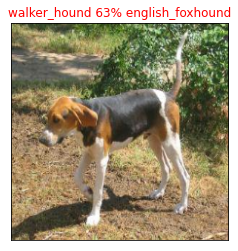

In [139]:

plot_preds(predictions_probabilities=predictions,
             labels=val_labels,
             images=val_images,
             n=42
             )

In [0]:
def plot_pred_top_10(prediction_probabilities, labels, n=1):
  ''''
  Plots the top 10 highest prediction confidences along with truth label for sample n.
  '''
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidences indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction labels
  top_10_pred_labels = unique_labels[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color='grey')
  
  plt.xticks(np.arange(len(top_10_pred_labels)),
              labels=top_10_pred_labels,
              rotation='vertical',
              color='white')

  plt.yticks(color='white')

  # Change the color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')
  else:
    pass

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


ValueError: ignored

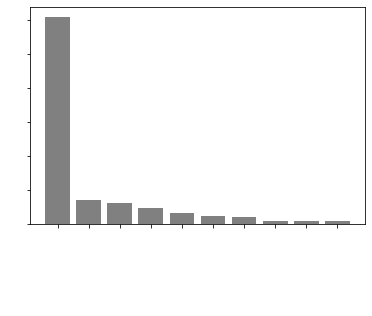

In [137]:
plot_pred_top_10(prediction_probabilities=predictions,
                labels=val_labels,
                n=9)